In [1]:
%matplotlib inline
import numpy as np
from scipy import stats, interpolate
from blimpy import Waterfall
from blimpy.utils import rebin
from matplotlib import pyplot as plt
from bisect import bisect_left
from tqdm import tqdm

MAX_PLT_POINTS      = 65536                  # Max number of points in matplotlib plot
MAX_IMSHOW_POINTS   = (8192, 4096)           # Max number of points in imshow plot

fil_path = "data/filterbanks/"
h5_path = "data/h5/"

test_fil = fil_path + "blc20_guppi_57991_48899_3C161_0007.gpuspec.0000.fil"

fri_obs = h5_path + "GBT_57532_09539_HIP56445_fine.h5"

plt_args = {
            'aspect':'auto',
            'origin':'lower',
            'rasterized':True,
            'interpolation':'nearest',
            'cmap':'viridis'
            }

In [2]:
def norm_test(arr):
    return stats.normaltest(arr.flatten())

In [3]:
def show_stamp(window, i):
    test_data = window[:, i:i+200]
    plt.figure()
    plt.imshow(test_data, **plt_args)

In [4]:
# Show Info
wf = Waterfall(fri_obs, load_data=False)
wf.info()

blimpy.file_wrapper INFO     Skipping loading data ...

--- File Info ---
b'DIMENSION_LABELS' : [b'frequency' b'feed_id' b'time']
     b'az_start' :                              0.0
    b'data_type' :                                1
         b'fch1' :                    1926.26953125
         b'foff' :           -2.835503418452676e-06
   b'machine_id' :                               20
        b'nbits' :                               32
       b'nchans' :                        318230528
         b'nifs' :                                1
  b'source_name' :                      b'HIP56445'
      b'src_dej' :                     3d03m34.006s
      b'src_raj' :                    11h34m21.699s
 b'telescope_id' :                                6
        b'tsamp' :                     17.986224128
       b'tstart' :                57532.11040509259
     b'za_start' :                              0.0

Num ints in file :                               16
      File shape :               (16,

/Users/yuhongc/PycharmProjects/BSRC_Env/lib/python3.6/site-packages/blimpy/file_wrapper.py:326: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  self.h5 = h5py.File(self.filename)


In [5]:
wf = Waterfall(fri_obs, f_stop=1070)
wf.info()


--- File Info ---
b'DIMENSION_LABELS' : [b'frequency' b'feed_id' b'time']
     b'az_start' :                              0.0
    b'data_type' :                                1
         b'fch1' :                    1926.26953125
         b'foff' :           -2.835503418452676e-06
   b'machine_id' :                               20
        b'nbits' :                               32
       b'nchans' :                        318230528
         b'nifs' :                                1
  b'source_name' :                      b'HIP56445'
      b'src_dej' :                     3d03m34.006s
      b'src_raj' :                    11h34m21.699s
 b'telescope_id' :                                6
        b'tsamp' :                     17.986224128
       b'tstart' :                57532.11040509259
     b'za_start' :                              0.0

Num ints in file :                               16
      File shape :               (16, 1, 318230528)
--- Selection Info ---
Data selection sh

In [6]:
coarse_channel_width = np.int(np.round(187.5/64/abs(wf.header[b'foff'])))
coarse_channel_width

1033216

In [7]:
freqs, data = wf.grab_data(f_start=0, f_stop=1070)
print(data.shape)
freqs = freqs[::-1]
data = data[:,::-1]

(16, 16249044)


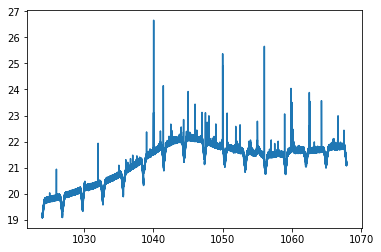

In [8]:
data = data[:, :15 * coarse_channel_width]
freqs = freqs[:15 * coarse_channel_width]

integrated = np.sum(data, axis=0)/len(data)
for n in np.nonzero(integrated > 10**13):
    integrated[n] = (integrated[n-1] + integrated[n+1]) /2
plt.figure()
plt.plot(freqs[:15*1033216], np.log(integrated))

In [9]:
channels = np.reshape(integrated, (-1, coarse_channel_width))

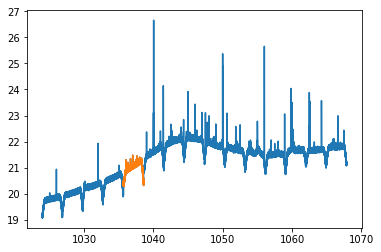

In [10]:
# plot spectrum and selected channel (logged)

channel_ind = 4
chan_freqs = freqs[coarse_channel_width * channel_ind: coarse_channel_width * (channel_ind+1)]
plt.figure()
plt.plot(freqs[:15*coarse_channel_width], np.log(integrated))


plt.plot(chan_freqs, np.log(channels[channel_ind]))

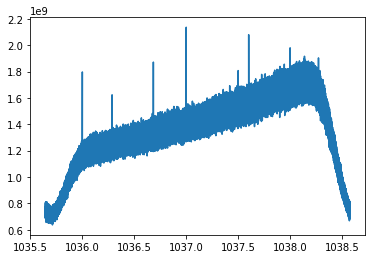

In [11]:
plt.figure()
plt.plot(chan_freqs, channels[channel_ind])

In [12]:
order = 16
knots = chan_freqs[::coarse_channel_width//order+1]
spl = interpolate.splrep(chan_freqs, channels[channel_ind], t=knots[1:])
chan_fit = interpolate.splev(chan_freqs, spl)

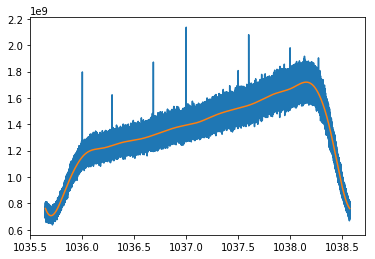

In [14]:
plt.figure()
plt.plot(chan_freqs, channels[channel_ind])
plt.plot(chan_freqs, chan_fit)

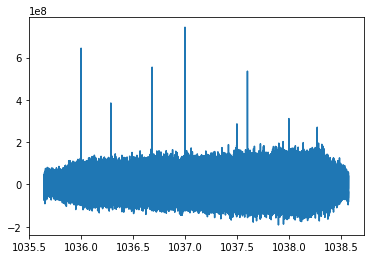

In [15]:
residuals = channels[channel_ind] - chan_fit
plt.figure()
plt.plot(chan_freqs, residuals)